<a href="https://colab.research.google.com/github/Patatone/Network-failure-cause-identification/blob/main/Failure_cause_identification_with_different_failures_location_IPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [10]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function should append to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function should also handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)

    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y

In [11]:
############################################################################################################
###### Performs hyperparameter optimization with 5-fold crossvalidation and training 
###### for XGB with given hyperparameters space 
###### XGB documentation at: https://xgboost.readthedocs.io/en/stable/python/python_intro.html 
###### XGB hyperparameters: https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html 
############################################################################################################

best_params_XGB = None
best_cv_acc_XGB = None

def train_classifier_XGB(X_train, y_train): 

    global best_params_XGB
    global best_cv_acc_XGB
    
    #F: define the search space for your hyperparameters - a space where to search
    # These parameters are needed to balance between underfitting and overfitting
    # We are testing 3 hyperparameters: eta, max_depth and subsample
    space4xgb = { 
     'eta': hp.choice('eta', [0.1, 0.3, 0.5, 0.7, 0.9, 1]),
     # max_depth (maximum depth of the decision trees being trained)
     'max_depth': hp.choice('max_depth', np.arange(1, 20, 2)),
     'subsample': hp.choice('subsample', [0.1, 0.3, 0.5, 0.7, 0.9, 1])
    }

    # hyperopt is used to perform an efficent search in the space of parameters
    def hyperopt_train_test(params):
        model = XGBClassifier(verbosity = 0, **params)
        #F: see https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
        
        return cross_val_score(model, X_train, y_train, cv = 5).mean()
        #F: cross_val_score is from scikit learn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
        #F: will use the default score (for XGB it is accuracy)
        #F: this includes also training; cv=5 (5 number of folds) (5-folds crossvalidation)
        #F: .mean() is taken as cross_val_score returns an array of scores (one for each fold)
        # We have to do the mean because "cross_val_score" returns the accuracy of all the folds

    #We pass to this function the "space4xgb" parameter (in fmin() function)
    #F: this function is used below, as a parameter to fmin
    def f(params): 
        # assumes that "hyperopt_train_test" gives use the best cross validation accuracy 
        # given that combination of hyperparameters (params)
        acc = hyperopt_train_test(params)
        #F: loss is returned as opposite (negative) of accuracy because we will use in 
        #f_min (that only minimizes), where we want to minimize the loss (i.e., maximize accuracy)
        # We need to return these parameters because fmin() requires them
        return {'loss': -acc, 'status': STATUS_OK} #F: loss is returned as opposite (negative) of accuracy because we will use in f_min (that only minimizes), where we want to minimize the loss (i.e., maximize accuracy)

    if best_params_XGB is None:
        trials = Trials()
        # best_params stores the index of the best parameters values according to the function
        # fmin() returns the indexes based on the minimum value of a passed function "f"
        # space4xgb is the search space
        # algo=tpe.suggest is the used alorithm
        # max_evals=5 is the maximum trials
        best_params_XGB = fmin(f, space4xgb, algo=tpe.suggest, max_evals=5, trials=trials)
        #F: see: https://github.com/hyperopt/hyperopt/blob/master/hyperopt/fmin.py
        #F: at this point, best_param is a dictionary where each key is the index of the corresponding best param in space4xgb
        print(best_params_XGB)
    
        #Insert in the paramets the values of the hyperparameters (not the indexes)
        best_params_XGB = hyperopt.space_eval(space4xgb, best_params_XGB)
        #F: this is used to extract from space4xgb the best values according to the indexes in best_params (and put such values in best_params)
        print(best_params_XGB)
    
        best_cv_acc_XGB = -round(trials.best_trial['result']['loss'], 2) #F: best across trials
        print('best_cv_acc: ' + str(best_cv_acc_XGB))

    xgb = XGBClassifier(eta = best_params_XGB['eta'], max_depth= best_params_XGB['max_depth'], 
                            subsample = best_params_XGB['subsample'], verbosity = 0) 

    t0 = time.time()
    #F: fit() is a function from scikit learn interface for XGB (https://xgboost.readthedocs.io/en/stable/python/python_intro.html#scikit-learn-interface), 
    # there is also train() that can be used directly with XGB objects (https://xgboost.readthedocs.io/en/stable/python/python_intro.html#training) 
    xgb.fit(X_train, y_train) 
    t1 = time.time()
    ex_time = t1 - t0
    print(ex_time)
    
    return xgb, ex_time


In [12]:
############################################################################################################
###### Performs hyperparameter optimization and training for DNN with given hyperparameters space 
############################################################################################################

best_params_DNN = None
best_cv_acc_DNN = None

def train_classifier_DNN(X_train, y_train): 

    global best_params_DNN
    global best_cv_acc_DNN

    #F: define the search space for your hyperparameters
    space4dnn = {
     'activation': hp.choice('activation', ['logistic', 'tanh', 'relu']),
     'neurons': hp.choice('neurons', [10, 50, 100]),
     'layers': hp.choice('layers', np.arange(1, 4, 1))
    }

    def hyperopt_train_test(params):
        size = (params['neurons'],) * params['layers']
        dnn = MLPClassifier(hidden_layer_sizes=size, activation=params['activation'],
                            solver='adam', learning_rate='invscaling', max_iter=1000)
        return cross_val_score(dnn, X_train, y_train, cv = 5).mean()

    def f(params):
        acc = hyperopt_train_test(params)
        return {'loss': -acc, 'status': STATUS_OK}

    if best_params_DNN is None:
        trials = Trials()
        best_params_DNN = fmin(f, space4dnn, algo=tpe.suggest, max_evals=5, trials=trials)
        print(best_params_DNN) 
    
        best_params_DNN = hyperopt.space_eval(space4dnn, best_params_DNN)
        print(best_params_DNN) 
    
        best_cv_acc_DNN = -round(trials.best_trial['result']['loss'], 2)
        print('best_cv_acc: ' + str(best_cv_acc_DNN))
    
    
    size = (best_params_DNN['neurons'],) * best_params_DNN['layers']
    dnn = MLPClassifier(hidden_layer_sizes=size, activation=best_params_DNN['activation'],
                                solver='adam', learning_rate='invscaling', max_iter=1000)

    t0 = time.time()
    dnn.fit(X_train, y_train)
    t1 = time.time()
    ex_time = t1 - t0
    print(ex_time)
    
    return dnn, ex_time


In [13]:
############################################################################################################
###### Performs hyperparameter optimization and training for KNN with given hyperparameters space 
############################################################################################################

best_params_KNN = None
best_cv_acc_KNN = None

def train_classifier_KNN(X_train, y_train): 

    global best_params_KNN
    global best_cv_acc_KNN

    #F: define the search space for your hyperparameters
    space4knn = {
     'leaf_size': hp.choice('leaf_size', np.arange(1, 50, 1)),
     'p': hp.choice('p', [1, 2]),
     'n_neighbors': hp.choice('n_neighbors', np.arange(1, 30, 1))
    }

    def hyperopt_train_test(params):
        knn = KNeighborsClassifier(leaf_size=params['leaf_size'], p=params['p'], 
                                   n_neighbors=params['n_neighbors'])
        return cross_val_score(knn, X_train, y_train, cv = 5).mean()

    def f(params):
        acc = hyperopt_train_test(params)
        return {'loss': -acc, 'status': STATUS_OK}

    if best_params_KNN is None:
        trials = Trials()
        best_params_KNN = fmin(f, space4knn, algo=tpe.suggest, max_evals=5, trials=trials)
        print(best_params_KNN) 
    
        best_params_KNN = hyperopt.space_eval(space4knn, best_params_KNN)
        print(best_params_KNN) 
    
        best_cv_acc_KNN = -round(trials.best_trial['result']['loss'], 2)
        print('best_cv_acc: ' + str(best_cv_acc_KNN))
    
    knn = KNeighborsClassifier(leaf_size=best_params_KNN['leaf_size'], p=best_params_KNN['p'], 
                                   n_neighbors=best_params_KNN['n_neighbors'])

    t0 = time.time()
    knn.fit(X_train, y_train)
    t1 = time.time()
    ex_time = t1 - t0
    print(ex_time)
    
    return knn, ex_time

In [14]:
################################################################################################################
###### Split (X,y) obtained in task 3b (they had window length=10 and spacing=1) into train/test ######
###### sets (80%/20%). Then, call functions train_classifier_XGB() and train_classifier_DNN(). ########
###### Save trained models (returned by the three functions) into .json files. ########################
################################################################################################################'

TRANING_TIMES = 5
lbl = [0, 1]

def training_alg(name, X_train, y_train, X_test, y_test):
    times, accuracies, global_precisions, global_recalls, global_f1scores = ([] for i in range(5))
    print(f'Training {name} {TRANING_TIMES} times...')
    for i in range(0,TRANING_TIMES):
        model, ex_time = train_classifier_XGB(X_train, y_train) 
        times.append(ex_time)
        
        # Added to fix: 'XGBClassifier' object has no attribute '_le'
        if (isinstance(model, XGBClassifier)):
            model._le = LabelEncoder().fit(y_test)
            
        y_pred = model.predict(X_test)
        accuracies.append(mt.accuracy_score(y_test, y_pred))
        global_precisions.append(mt.precision_score(y_test, y_pred, labels=lbl, average='weighted'))
        global_recalls.append(mt.recall_score(y_test, y_pred, labels=lbl, average='weighted'))
        global_f1scores.append(mt.f1_score(y_test, y_pred, labels=lbl, average='weighted'))
    
    stats = [times, accuracies, global_precisions, global_recalls, global_f1scores]
    return stats

def training(X, y):
    # Stratify garantees the split all the scenarios among train and test
    # It's like shuffle and split
    # random_state it's a seed to get the same output
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    print(y_test)
    print(X_test)
    
    xgb_stats = training_alg('XGB', X_train, y_train, X_test, y_test)
    dnn_stats = training_alg('DNN', X_train, y_train, X_test, y_test)
    knn_stats = training_alg('KNN', X_train, y_train, X_test, y_test)
    
    return xgb_stats, dnn_stats, knn_stats


In [15]:
##########################################################################################
###### Use function load_window_dataset() with datasets of for all scenarios  
###### using window length = 10 and spacing = 1. Finally, perform features scaling 
##########################################################################################

X=None 
y=None

#All scenario correlated ONLY TO "length=10" and "spacing=1"
length=10
spacing=1
folderpath='../Features'

for filename in os.listdir(folderpath):
    #F: you should continue iterating over "Features" folder looking for the desired files    
    if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
        print(filename)
        label = 0
        if int(filename[9]) > 5:
          label = 1
        fullname = folderpath + '/' + filename
#------------------------------------------------------------
        X, y = load_window_dataset(X, y, fullname, label)
#------------------------------------------------------------
        print('current shape of X: ' +str(X.shape))
        print('current shape of y: ' +str(y.shape))


scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

xgb_stats_not_norm, dnn_stats_not_norm, knn_stats_not_norm = training(X, y)
xgb_stats_norm, dnn_stats_norm, knn_stats_norm = training(X_norm, y)

Scenario_1_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (21591, 6)
current shape of y: (21591,)
Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (43182, 6)
current shape of y: (43182,)
Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of X: (64773, 6)
current shape of y: (64773,)
Scenario_2_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (86364, 6)
current shape of y: (86364,)
Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (107955, 6)
current shape of y: (107955,)
Scenario_3_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (129546, 6)
current shape of y: (129546,)
Scenario_4_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (151137, 6)
current shape of y: (151137,)
Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (172728, 6)
current shape of y: (172728,)
Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of

In [16]:
def candle_normalization_impact(alg_name, stats_label, stats_norm, stats_not_norm):
    fig_folder = '1_2_Figures'
    if not os.path.exists(fig_folder):
        os.makedirs(fig_folder)
    
    lables = ['Normalized','Not Normalized']

    fig, ax = plt.subplots(figsize=(15,8))
    bplots = []
    bplots.append(ax.boxplot(stats_norm, positions = [0], patch_artist=True))
    bplots.append(ax.boxplot(stats_not_norm, positions = [1], patch_artist=True))

    for bplot in bplots:
        for patch in bplot['boxes']:
            patch.set_facecolor('lightblue')
    
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.grid(1)
    plt.xticks(ticks = list(range(2)), labels = lables, fontsize = 14)
    plt.setp(ax.xaxis.get_majorticklabels(), ha="center") 
    if (stats_label == 'Traning Time'):
        plt.ylabel('Seconds', color='black', fontsize=14)
    image_title=alg_name+' Normalization Impact on ' + stats_label
    plt.title(image_title, fontsize=14)
    plt.show()
    fig.savefig(fig_folder+'/'+image_title.replace(" ", "_")+'.png')

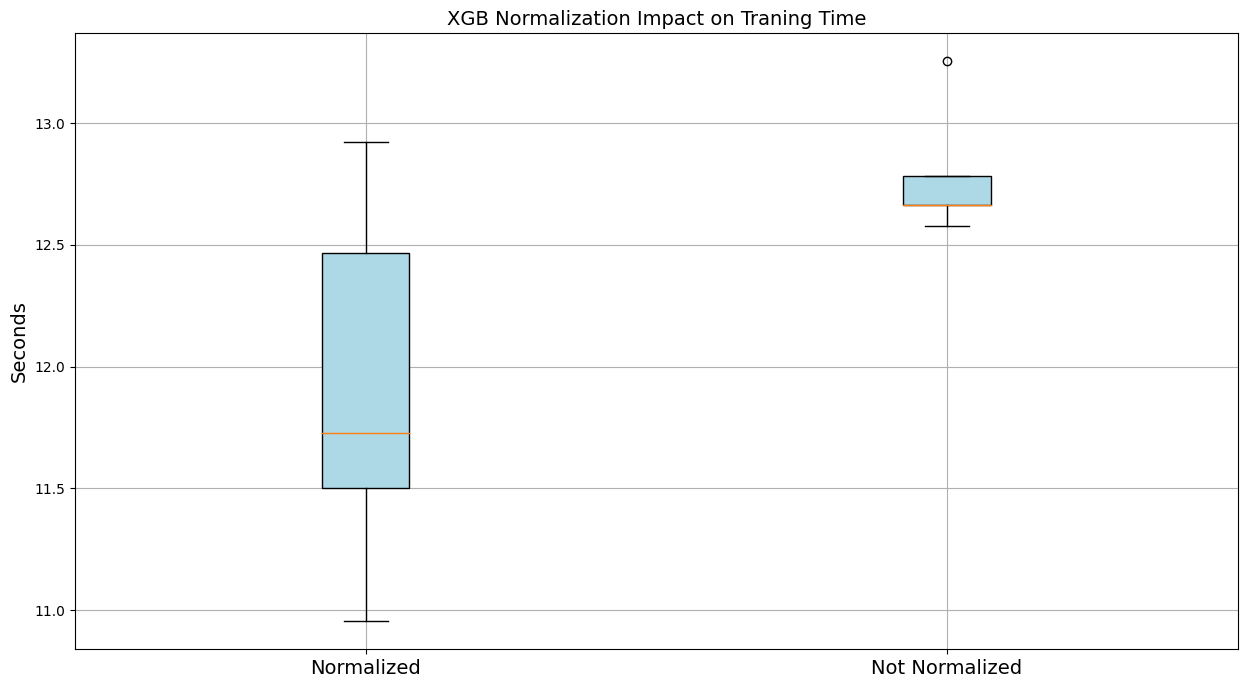

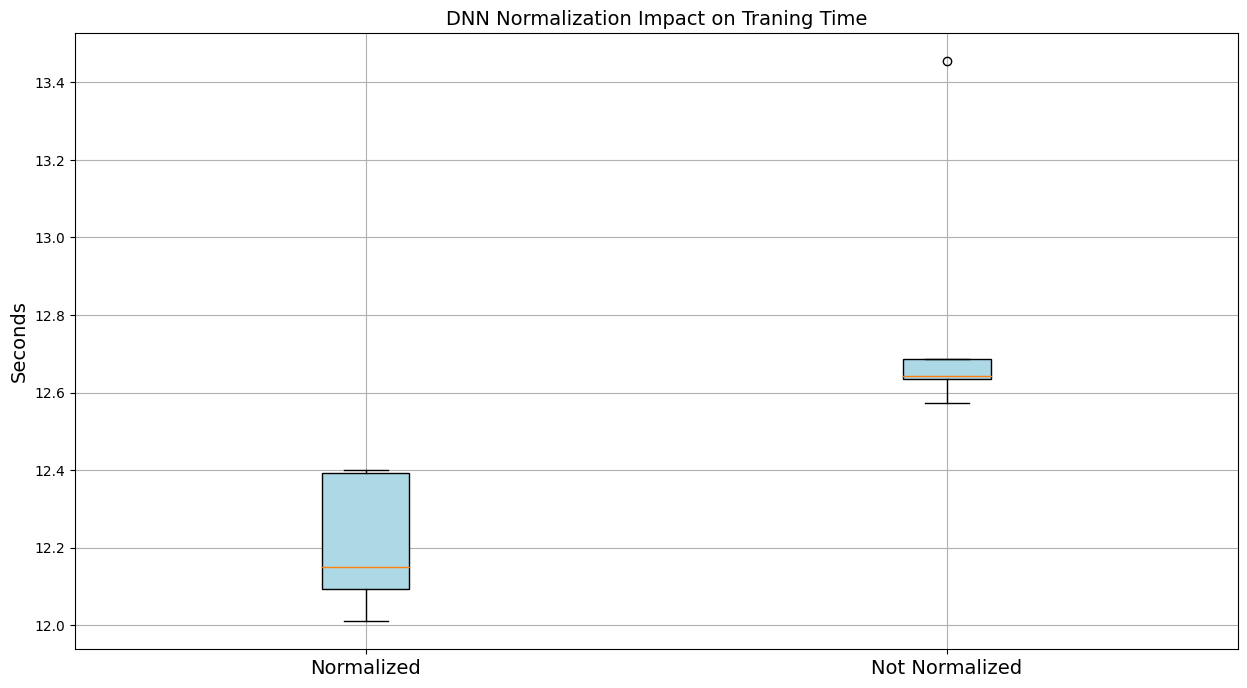

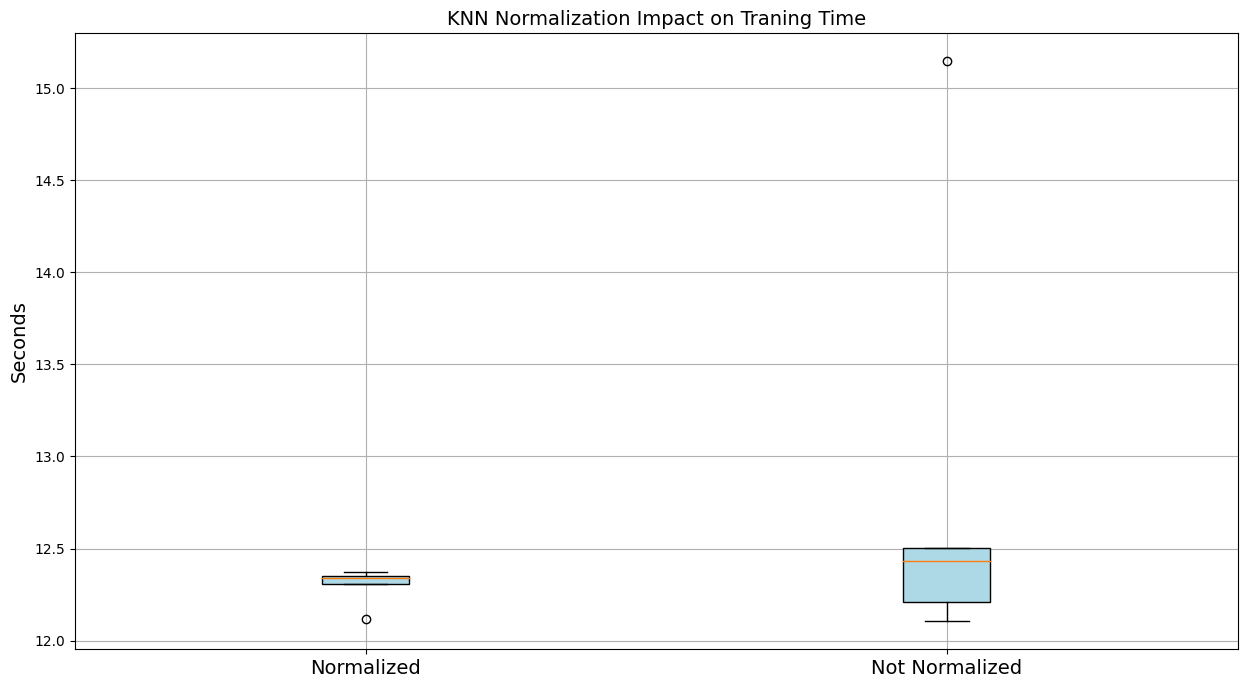

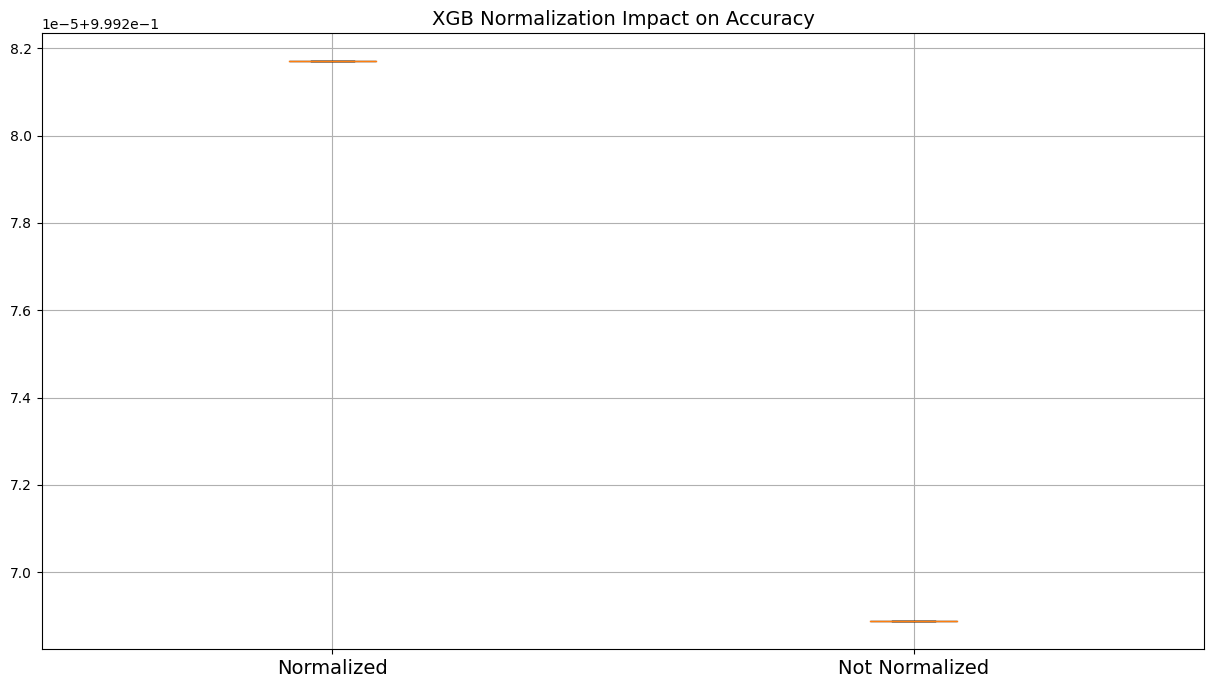

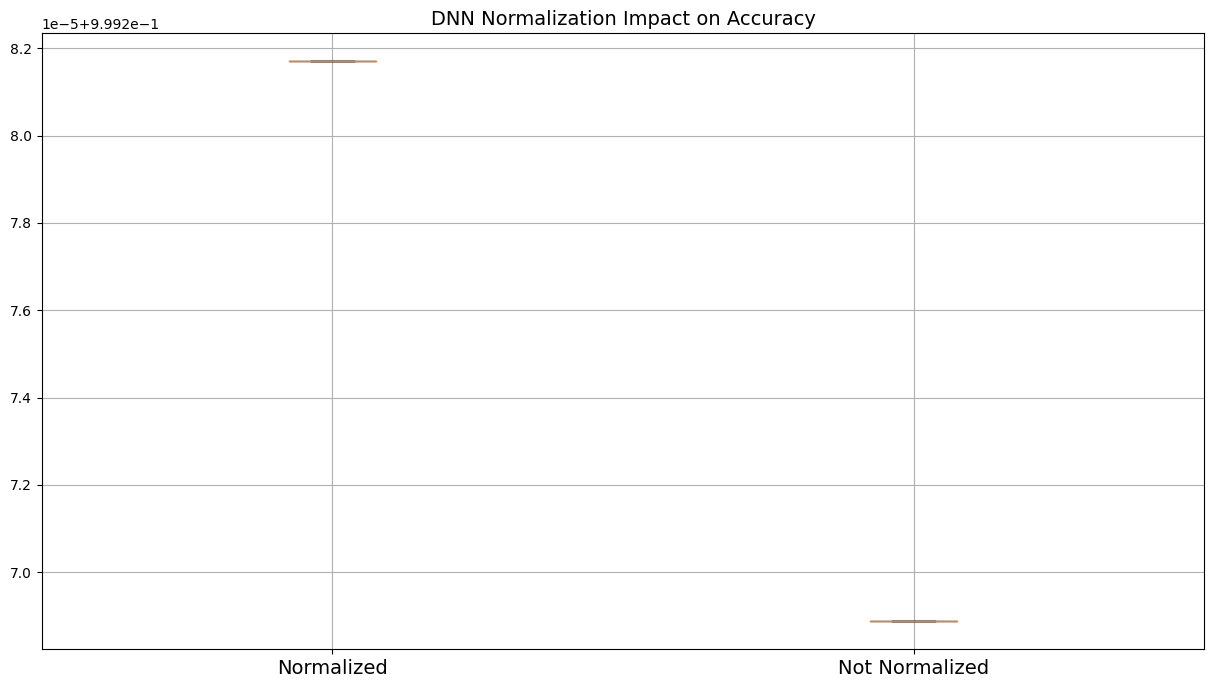

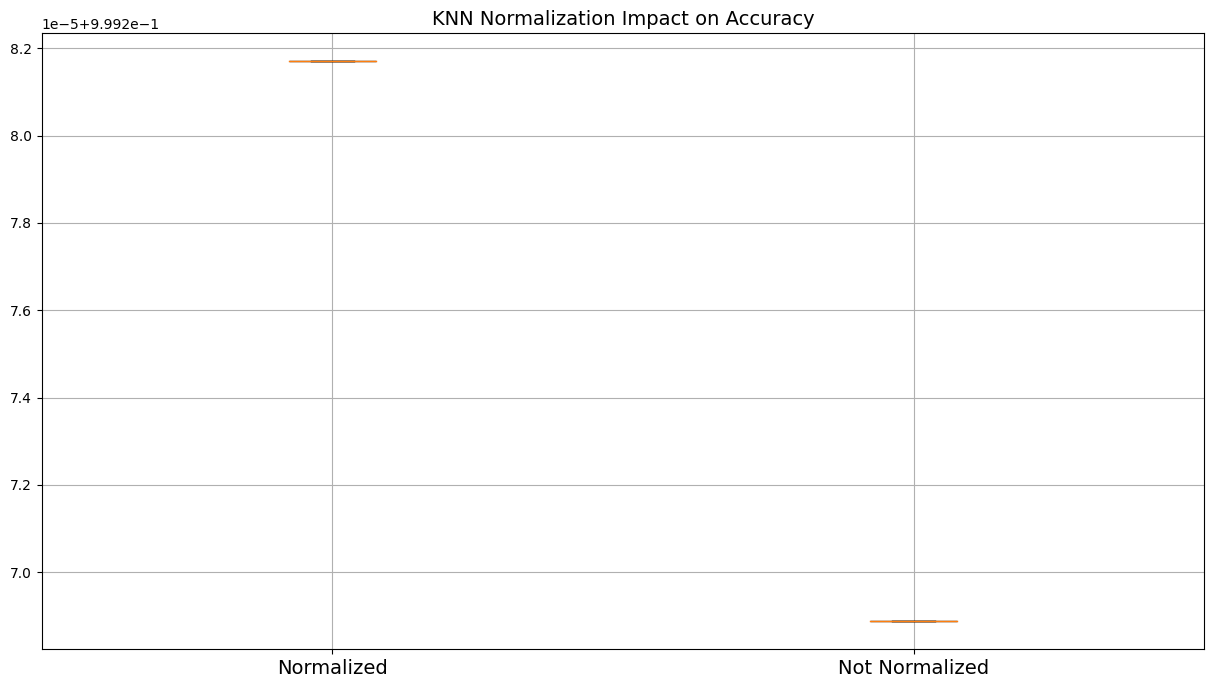

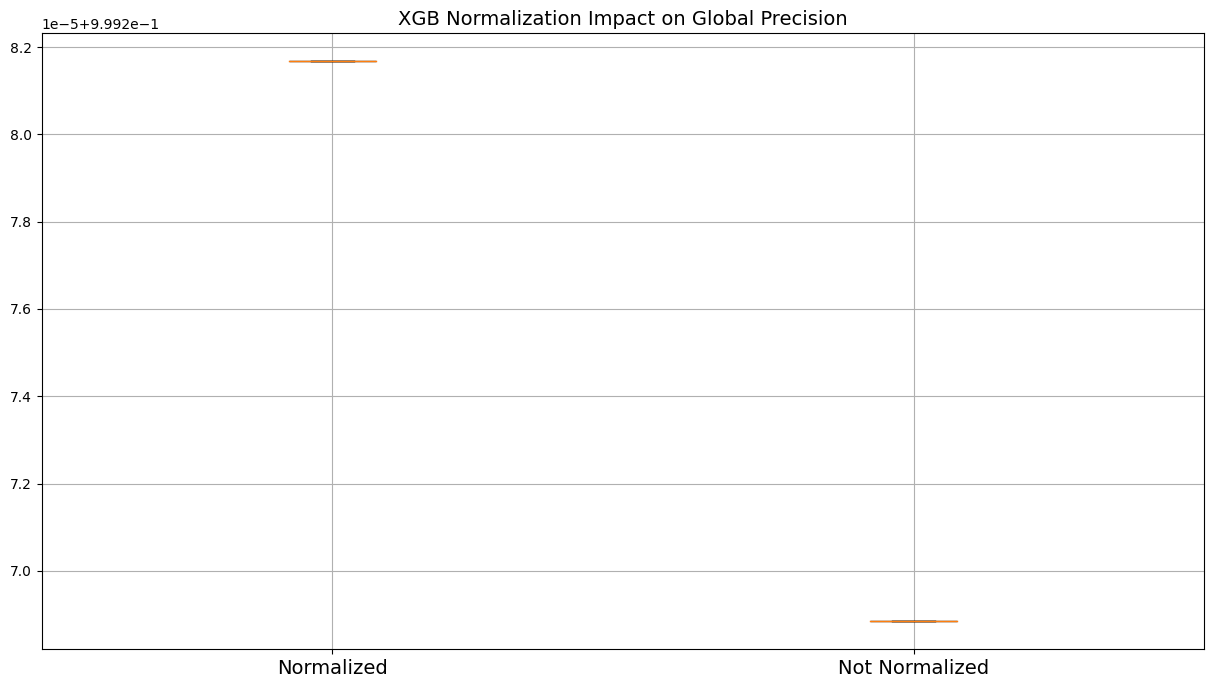

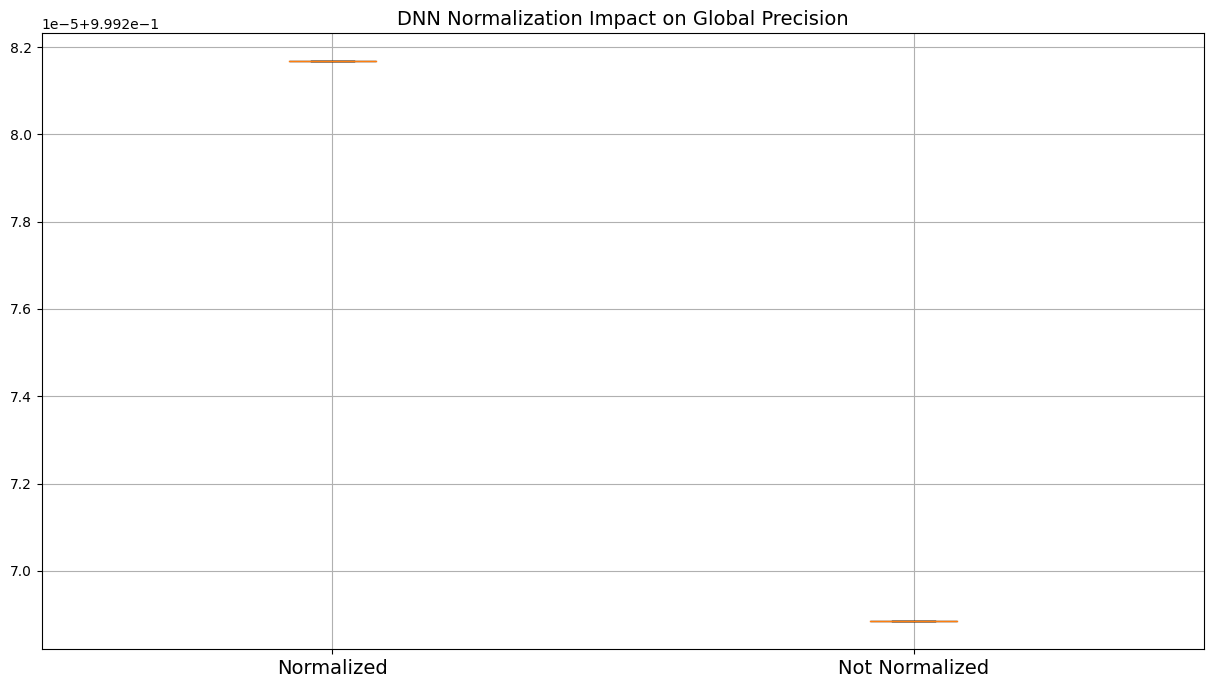

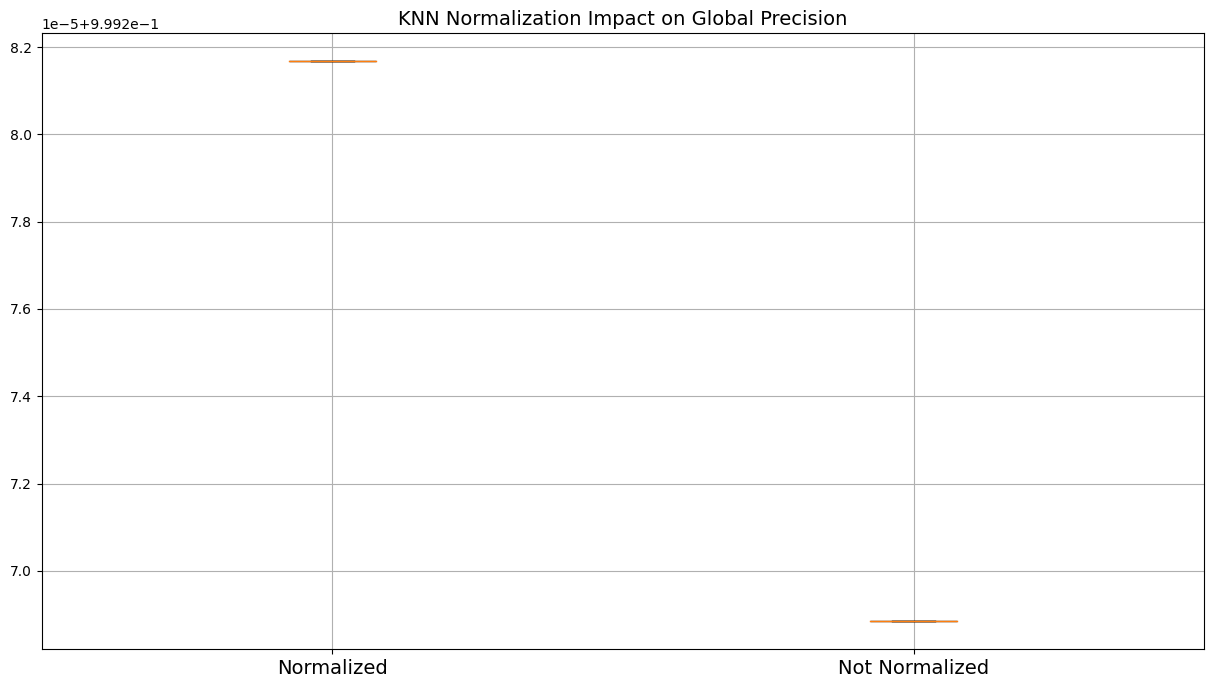

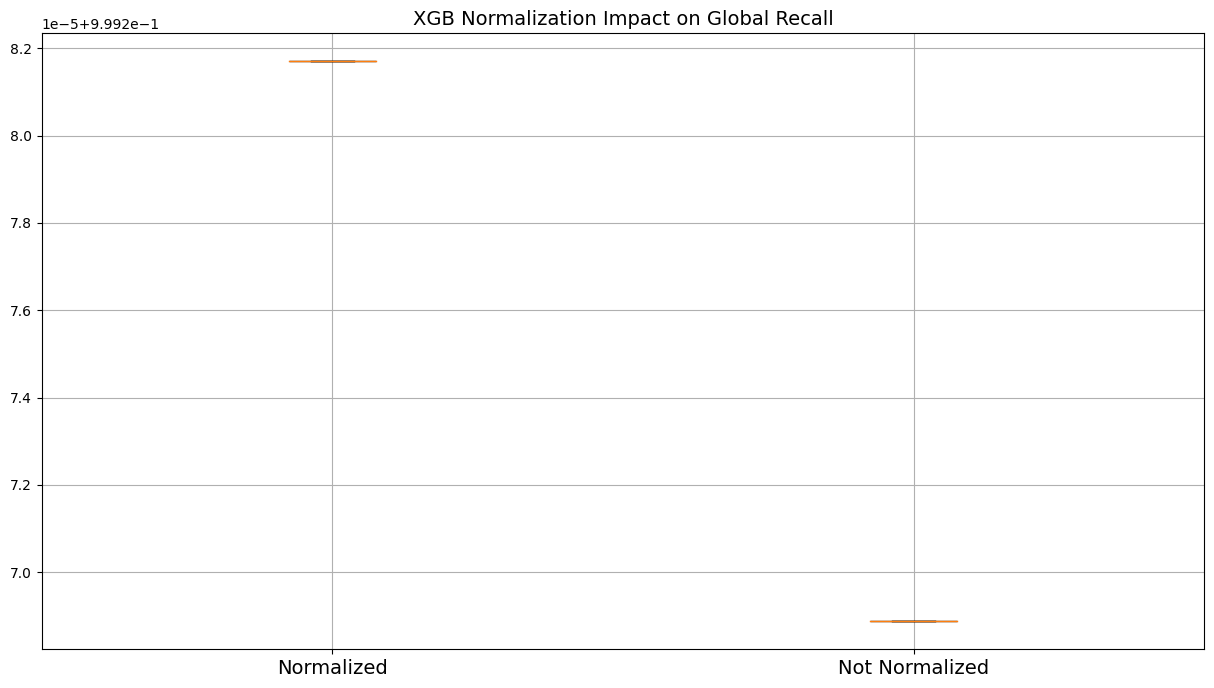

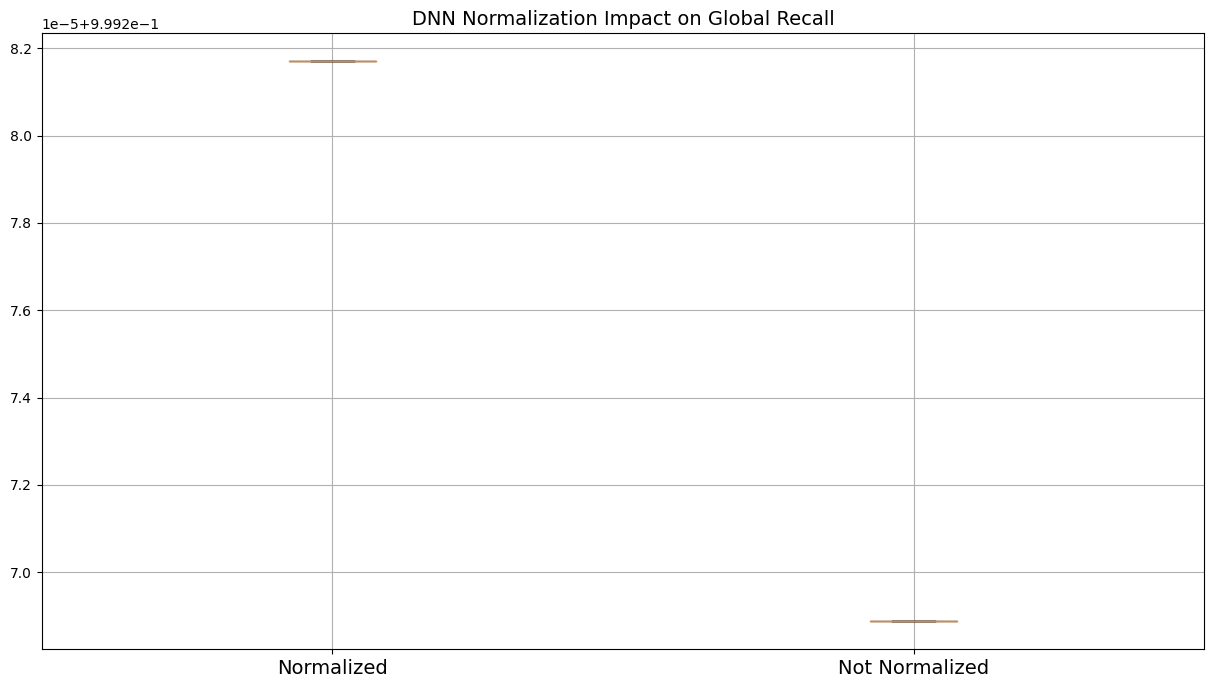

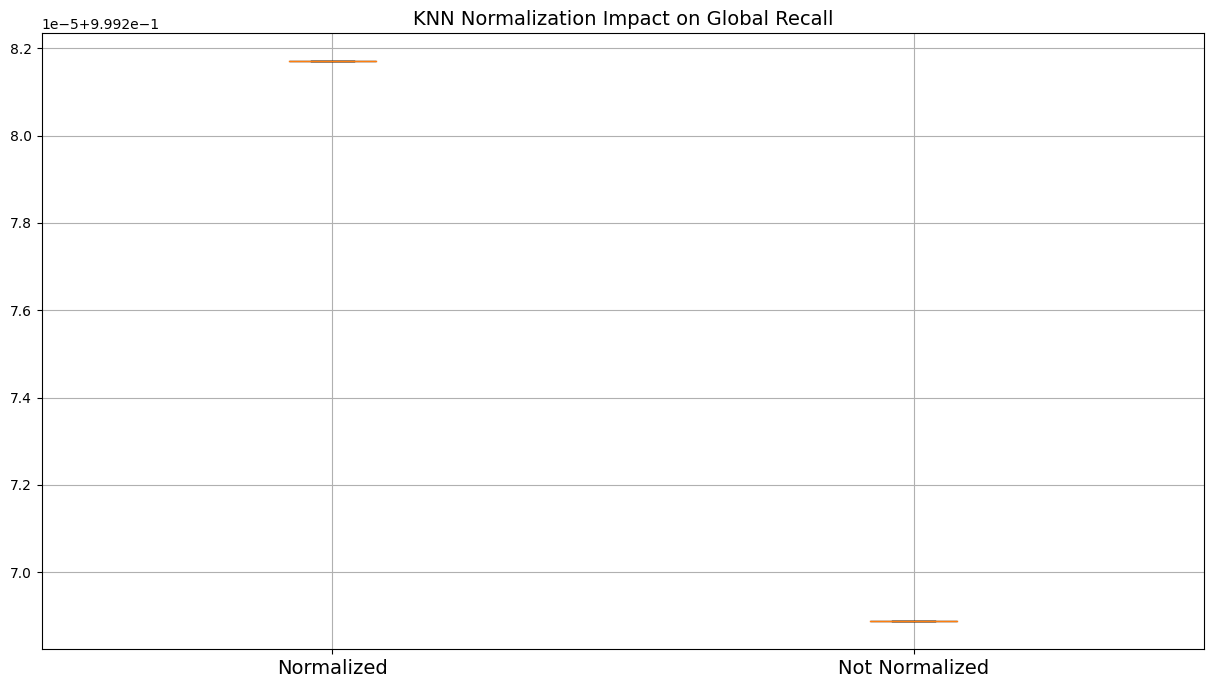

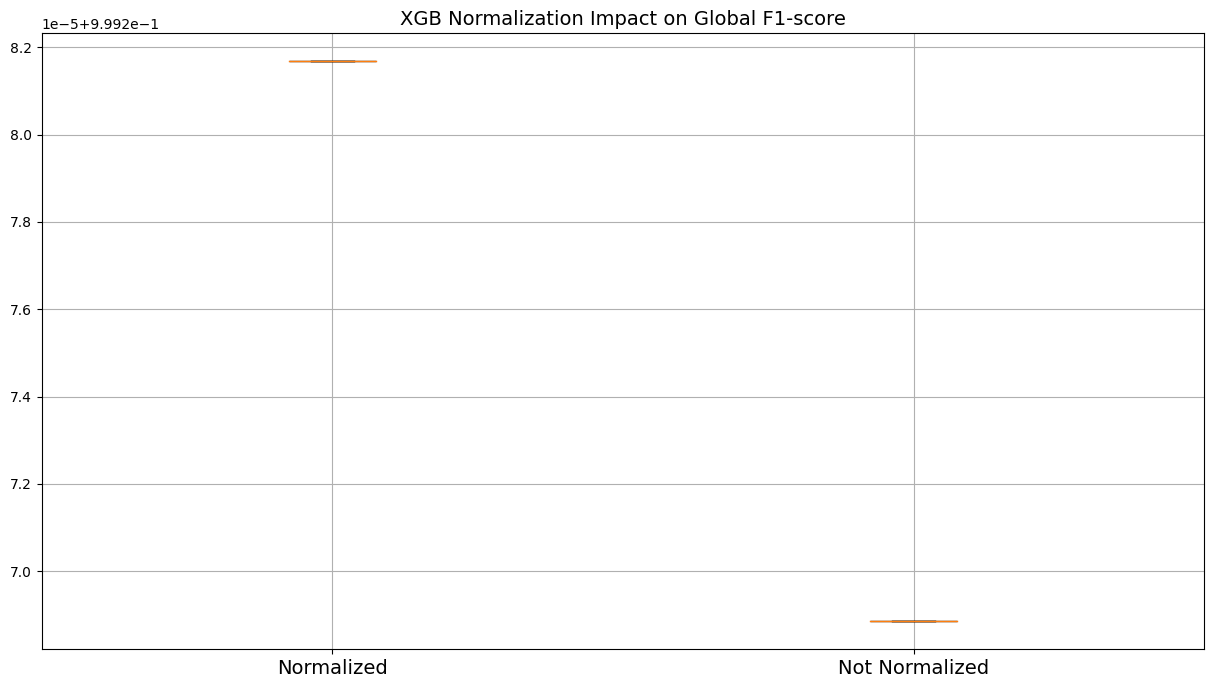

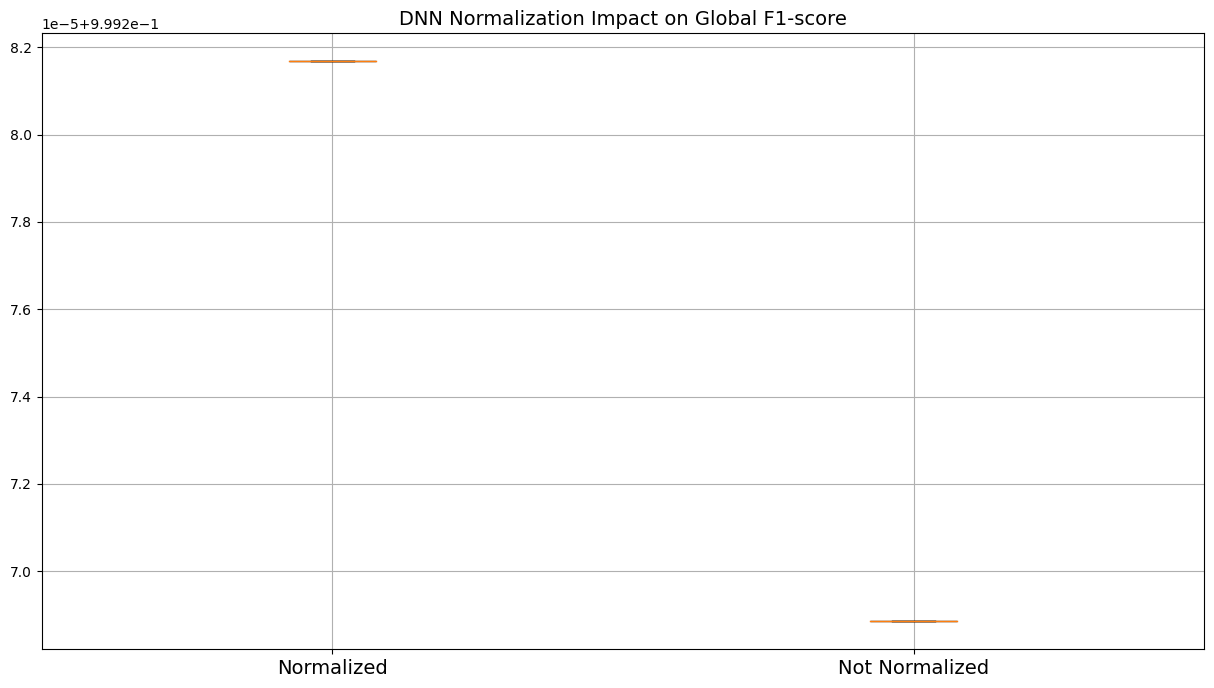

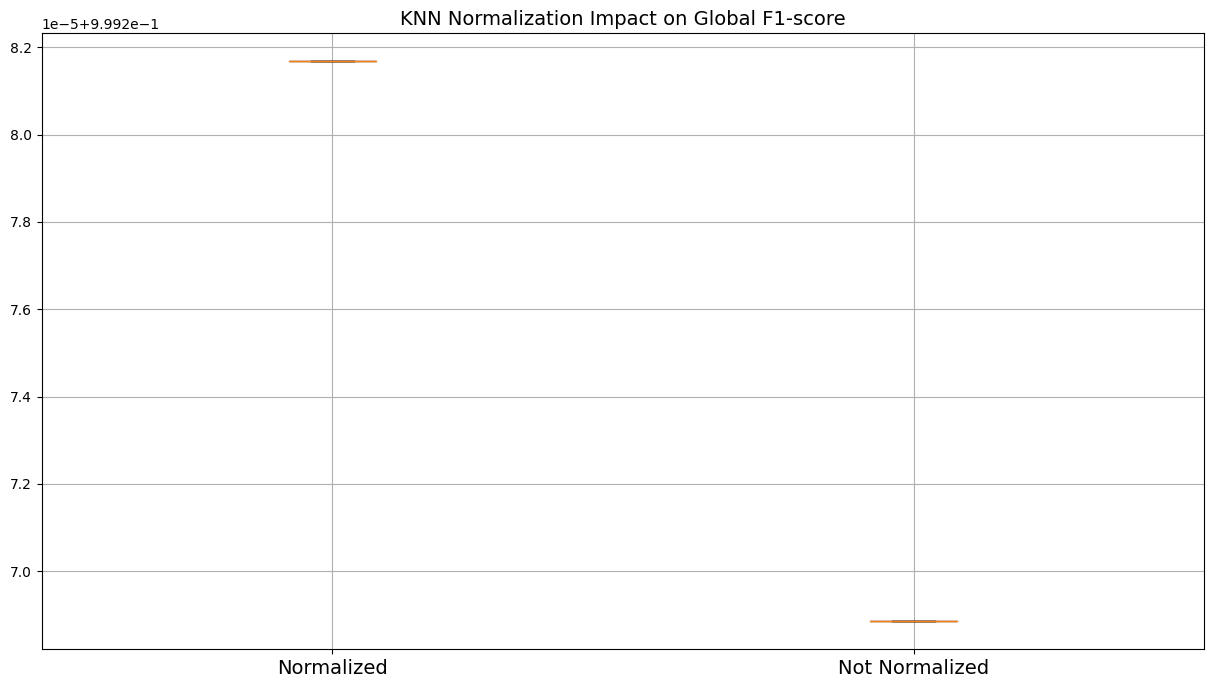

In [17]:
stats_label= ['Traning Time', 'Accuracy', 'Global Precision', 'Global Recall', 'Global F1-score']
    
for i in range(0, 5):
    candle_normalization_impact('XGB', stats_label[i], xgb_stats_norm[i], xgb_stats_not_norm[i])    
    candle_normalization_impact('DNN', stats_label[i], dnn_stats_norm[i], dnn_stats_not_norm[i])
    candle_normalization_impact('KNN', stats_label[i], knn_stats_norm[i], knn_stats_not_norm[i])
    